# Лабораторная № 1
## Вариант 17
$$ f(x)=9+3.5\cdot cos(\frac{x-30}{ 12 }) $$
### Задача 1.
На данных своего варианта (см. второй столбец таблицы с вариантами) повторить расчёты
и построить графики из первой лабораторной. Пояснить выбор наилучшего количества степеней
свободы.
### Задача 2.
Повторить расчёты, меняя характеристики согласно своему варианту (см. последний
столбец таблицы с вариантами). Проанализировать, как меняется MSE при изменении характеристики 
`n_all`=[450, 400, 350]

In [204]:
# загрузка пакетов
import numpy as np
import random
import pandas as pd
from pandas import DataFrame
import rpy2.robjects as robjects

In [205]:
np.random.seed(17)
n_all, train_percent = 60, 0.85

x_min, x_max = 5, 105
x = np.random.uniform(x_min, x_max, n_all)

mu, sigma = 0, 1
res =  np.random.normal(mu, sigma)

in_train = np.random.choice(np.arange(n_all),
                            int(n_all * train_percent), replace=False)

y_func = lambda x: 9 + 3.5 * np.cos((x-30)/12)

x_line = np.linspace(x_min, x_max, n_all)
y_line = y_func(x_line)

y = y_func(x) + res

x_train = x[in_train]
y_train = y[in_train]

x_test = np.delete(x, in_train)
y_test = np.delete(y, in_train)

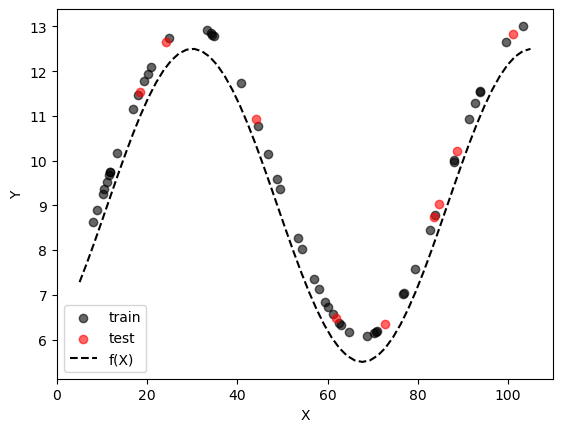

In [206]:
import matplotlib.pyplot as plt
plt.scatter(x_train, y_train, c='black', label='train', alpha=0.6)
plt.scatter(x_test, y_test, c='red', label='test', alpha=0.6)
plt.plot(x_line, y_line, c='black', linestyle='dashed', label='f(X)')
plt.xlabel('X')
plt.ylabel('Y')
plt.legend()
plt.show()

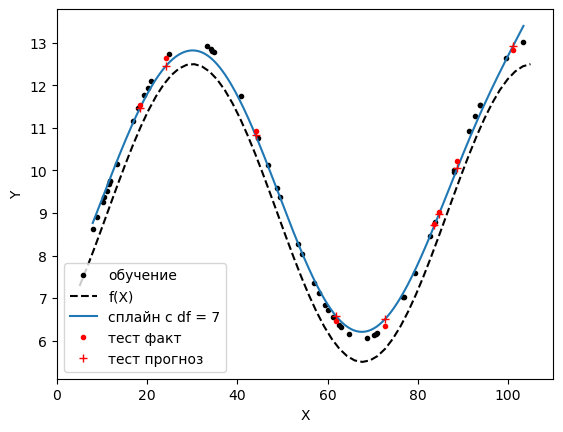

In [207]:
my_df = 7
x_sorted_index = sorted(range(len(x_train)), key=lambda k: x_train[k])
x_train_lin = np.linspace(min(x_train), max(x_train), num=300, endpoint=True)

r_x = robjects.FloatVector(x_train)
r_y = robjects.FloatVector(y_train)

r_smooth_spline = robjects.r['smooth.spline']

fit = r_smooth_spline(x=r_x, y=r_y, df=my_df)

# делаем прогнозы
y_hat_train = np.array(robjects.r['predict'](fit,
robjects.FloatVector(x_train)).rx2('y'))
y_hat_test = np.array(robjects.r['predict'](fit,
robjects.FloatVector(x_test)).rx2('y'))
y_lin_plot = np.array(robjects.r['predict'](fit,
robjects.FloatVector(x_train_lin)).rx2('y'))

# строим график
plt.plot(x_train, y_train, color='black', ls='', marker='.', label='обучение')
plt.plot(x_line, y_line, color='black', ls='dashed', marker='', label='f(X)')
plt.plot(x_train_lin, y_lin_plot, marker='', label='сплайн с df = %s' % my_df)
plt.plot(x_test, y_test, color='red', ls='', marker='.', label='тест факт')
plt.plot(x_test, y_hat_test, color='red', ls='', marker='+', label='тест прогноз')
# подписи осей
plt.xlabel('X')
plt.ylabel('Y')
# легенда
plt.legend(loc='best')
# считаем MSE
MSE_fit = [sum((y_train - y_hat_train)**2) / len(y_train),
sum((y_test - y_hat_test)**2) / len(y_test)]

In [208]:
 # выводим MSE с округлением
np.around(MSE_fit, 2)

array([0.02, 0.01])

In [209]:
# максимальное число степеней свободы для модели сплайна
max_df = 16
# фрейм данных для сохранения MSE на обучающей и на тестовой
# при разных степенях свободы
MSE_all_dfs = [[0] * 2 for i in range(2, max_df+1)]
MSE_all_dfs = DataFrame(MSE_all_dfs, columns=['MSE_train', 'MSE_test'],
index=list(range(2, max_df+1)))
# заполняем фрейм
for i_df in range(2, max_df+1) :
    # обучаем модель
    fit = r_smooth_spline(x=r_x, y=r_y, df=i_df)
    # прогноз на обучающей выборке
    y_train_hat = np.array(robjects.r['predict'](fit,
    robjects.FloatVector(x_train)).rx2('y'))
    # прогноз на тестовой выборке
    y_test_hat = np.array(robjects.r['predict'](fit,
    robjects.FloatVector(x_test)).rx2('y'))
    # считаем MSE
    MSE_all_dfs.loc[i_df, 'MSE_train'] = \
    sum((y_train - y_train_hat)**2) / len(y_train_hat)
    MSE_all_dfs.loc[i_df, 'MSE_test'] = \
    sum((y_test - y_test_hat)**2) / len(y_test_hat)

In [214]:
# фильтруем таблицу по минимальной MSE на тестовой выборке
MSE_all_dfs[MSE_all_dfs['MSE_test'] == min(MSE_all_dfs['MSE_test'])]

,MSE_train,MSE_test
16,0.0001,0.00015


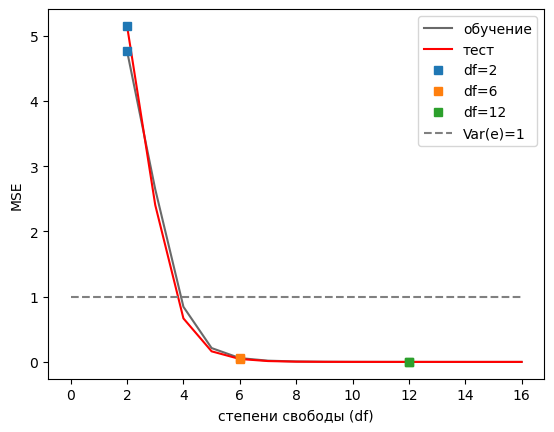

In [211]:
# график изменения MSE с увеличением df
plt.plot(MSE_all_dfs.index, MSE_all_dfs['MSE_train'], color='dimgrey',
marker='', label='обучение')
plt.plot(MSE_all_dfs.index, MSE_all_dfs['MSE_test'], color='red',
marker='', label='тест')
plt.plot([2, 2], [MSE_all_dfs.iloc[0]['MSE_train'],
MSE_all_dfs.iloc[0]['MSE_test']],
ls='', marker='s', label='df=2')
plt.plot([6, 6], [MSE_all_dfs.iloc[4]['MSE_train'],
MSE_all_dfs.iloc[4]['MSE_test']],
ls='', marker='s', label='df=6')
df_inf = 12
plt.plot([df_inf, df_inf], [MSE_all_dfs.iloc[df_inf+2]['MSE_train'],
MSE_all_dfs.iloc[df_inf+2]['MSE_test']],
ls='', marker='s', label=f'df={df_inf}')
plt.hlines(1, 0, max_df, linestyles='dashed', color='grey', label='Var(e)=1')
# подписи осей
plt.xlabel('степени свободы (df)')
plt.ylabel('MSE')
# легенда
plt.legend(loc='best')
plt.show()
